# Multi-Armed Bandit 

Multi-Armed Bandits are a type of Reinforcement Learning algorithmn that is used to learn the best actions to maximize an expected gain. The algorithm learns about the distribution of the gain for the different actions over time by using an exploration(aquire new knowledge and exploitation(optimize the decisions based on existing knowledge) tradeoff stragegy. The agent attempts to balance these competing tasks in order to maximize the total gain over time.


## Epsilon Greedy
$\epsilon$ = probability of exploration.  This is the is the percentage of exploration actions the agent will take. For example if $\epsilon$=0.05, then 5% of actions will be exploration, and 95% will be exploitation. 

Epsilon Greedy allows the agent to explore all actions. The agent learns the best actions by updating the mean of each bandit after each action is taken. 

After the optimal actions are identified, the epsilon greedy algorithm will still explore suboptimal actions at the rate of $\epsilon$.

## Optimistic Initialization
Optimistic intialization is an alternative to the epsilon greedy algorithm. It forces the agent to explore all actions by setting the inital mean of all the bandits as very high, ie an upper limit. Means should be selected to be much higher than what the true mean could be. This forces the agent to explore all the bandits, and the bandit's means will decrease quickly. 

## UCB1
Similar to optimistic initalization, UCB1 initializes the mean of the bandits using an upper bound. This upper bound is based on confidence bounds and is determined by the Hoeffding’s Inequality.
$$P\{|\bar{X}-\mu| \geq \epsilon\} \leq 2e^{-2\epsilon^2N}$$
which rearranges to an upper bound on the mean for the jth bandit
$$X_{UCB-j}=\bar{X_j}+\sqrt{2\frac{lnN}{N_j}}$$
Where N is the number of times all bandits have been played. 

This allows the initialized mean values of the bandits to shrink as the agent tries each bandit, and becomes more confident in our estimate of the bandits true mean. 

## Bayesian Multi-Armed Bandits

In the bayesian multiarmed bandit, the an upper limit is used to initalize the means of the bandits. The upper limit is a upper confidence bound calculated using a distribution of the mean given the observed data, $p(\mu|X)$. This is the posterior of $\mu$.

We use bayes rule to calculate the posterior. 

$$p(\mu|X)=p(X|\mu)p(\mu)$$

We assume X follow a normal $X \sim Normal(\mu, \sigma^2/N)$.

And we put a prior on the mean $\mu \sim Beta(a, b)$

The upper limit is selected as the max of the samples from each of the bandits. The distribution is fat )has large confidence intervals) when few samples have been observed, and becomes skinnier as we approximate the true mean. 

In [ ]:
from src.reinforcement_learning import GreedyBandit, OptimisticBandit, UCB1Bandit, BayesianBandit

In [ ]:
bandits = GreedyBandit.perform_epsilon_greedy(bandit_true_means=[0.01, 0.05, 0.5], N=1000, epsilon=0.1)
for b in bandits: print(b.mean)   

In [ ]:
bandits = OptimisticBandit.perform_optimistic_initialization(bandit_true_means=[0.01, 0.05, 0.5], N=1000, upper_limit=10)
for b in bandits: print(b.mean)

In [ ]:
bandits = UCB1Bandit.perform_ucb1(bandit_true_means=[0.01, 0.05, 0.5], N=1000, upper_limit=10)
for b in bandits: print(b.mean)

In [ ]:
bandits = BayesianBandit.perform_bayesian_bandits(bandit_true_means=[0.01, 0.05, 0.5], N=1000)
for b in bandits: print(b.mean)

# Contexual Multi-Armed Bandits for Recommender System

Contexual Multi-Armed Bandits use the MAB framework to recommend items to users. Actions are decided based on the expected reward, and based on a state learned from the user's data. As a result, the recommendations are personalized at the user level. 

"The algorithm observes a context, makes a decision, choosing one action from a number of alternative actions, and observes an outcome of that decision. An outcome defines a reward. The goal is to maximize average reward."

Why this and not a traditional ML algorithm that retrains when it gets new info?
* cause of cold start. It makes informed neighborhood recs that optimize the probability they will enage with eh the item quickly, and give us engagemetn sthat will segment.
* Not cause of live learning. i mean you get taht from retraining it would update with new info
* cause of explore exploit tradeoff? Np. a trained ML algo would still explore in a sense it would recoomemdn things we _think_ they would like, but when retrain we encorporate what we learned from taht smart exploration. 
* So why then? Just cold start? Yeah. Both rec cold start and frequency are same problem. No data on the user yet. 

A particularly useful version of the multi-armed bandit is the contextual multi-armed bandit problem. In this problem, in each iteration an agent has to choose between arms. Before making the choice, the agent sees a d-dimensional feature vector (context vector), associated with the current iteration. The learner uses these context vectors along with the rewards of the arms played in the past to make the choice of the arm to play in the current iteration. Over time, the learner's aim is to collect enough information about how the context vectors and rewards relate to each other, so that it can predict the next best arm to play by looking at the feature vectors


Can I crete a bayesian network/graphical model similar to VAE to model this?

I want to use MAB to solve 2 challenges in recommender systems:
1. The cold start problem. 

Recommend items to new users in a way that will optimize our chances of them engaging with the item. Goal is to collect interaction data from these new users so that we can train a ML recommender. The items shown to users should have a high change of being interacted with, while still informing us about the kind of user they are, meaning the items should represent distinct clusters of users. =  The baselien for this is popularity recs, and it is expected to outperform because the items shown can segment users instead of jsut get interactions.  

2. Make frequency of contact recommendations that drive engagement in the environment where there is not enough variance in historical data to train an ML model, and more items will always increase cliks, but cause user fautifue resulting in unsubscribes. This leaverages the explor exploit tradeoff that MAB's offer, while solving the existing cold start problem. 

For frequency optimization, frequency has not changed at all. Meaning each user has only seem one item. The goal is to use the MAB to vary frequency in real time while optimizing the tradeoff between engagements and dissengagements. 

The MAB balances the tradeoff between exploitation and exploration, which will allow us to safely vary frequency enough to learn the right policy, while maximizing the customers probability of engaging. 



# Example - Contexual Multi-Armed Bandits Book Recommender

## Formatting the data

In [414]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np

books = pd.read_csv('data/book_ratings.csv', sep=";", escapechar='\\', encoding='CP1252', low_memory=False)
books.columns = ["user", "isbn", "rating"]

#subset data to top n books
n=15
top_n_books = books.isbn.value_counts().index[:15].tolist()
books = books.query('isbn in @top_n_books')
print("{} unique users".format(books.user.nunique()))
print("{} unique books".format(books.isbn.nunique()))

#remove read but unrated books
books = books.query('rating > 0')

#remove users who only rated one thing. 
vc = books.user.value_counts()
keep_users = vc[vc > 1].index

books = books.query('user in @keep_users')

print(books.shape)
books.head(3)

7842 unique users
15 unique books
(1676, 3)


,user,isbn,rating
1965,277439,0316666343,7
1973,277439,0671027360,7
9962,243,0316601950,9


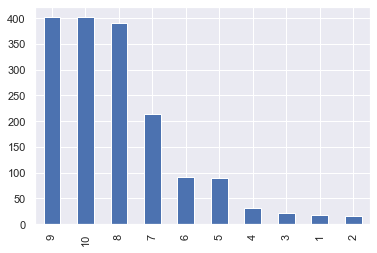

Average rating: 8.0507


In [415]:
#ratings are on a scale of 1-10.
books.rating.value_counts().plot(kind="bar")
plt.show()
print("Average rating: {}".format(np.round(books.rating.mean(),4)))

Average number of ratings per user: 2.4396


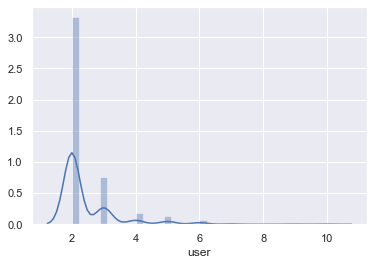

In [416]:
#how many books are people rating on average?
sns.set(); np.random.seed(0)
x = books.user.value_counts()
ax = sns.distplot(x)
print("Average number of ratings per user: {}".format(np.round(x.mean(),4)))

In [417]:
#make action columns
books["action"] = books["isbn"]
book_action_mapping = dict(zip(books.action.unique(), range(15)))
action_book_mapping = dict(zip(range(15), books.action.unique()))
feature_names = list(book_action_mapping.keys())
books = books.replace({"action": book_action_mapping})
books.head()

,user,isbn,rating,action
1965,277439,0316666343,7,0
1973,277439,0671027360,7,1
9962,243,0316601950,9,2
10001,243,044023722X,7,3
10084,254,0142001740,9,4


In [418]:
#make context column

books_context = books.pivot(index='user', columns='isbn', values='rating')
books_context.fillna(0, inplace=True)

books = pd.merge(books, books_context, left_on="user", right_index=True, how="left")
books.reset_index(inplace=True, drop=True)

In [419]:
all_context=[]
for i in books.index:
    action =  books.loc[i].action
    context = books.loc[i, feature_names].values.astype(float)
    context[action] = 0
    all_context.append(context)

books["context"] = all_context

In [420]:
books = books[["user", "action", "rating", "context"]]
books.head()

,user,action,rating,context
0,277439,0,7,"[0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,277439,1,7,"[7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,243,2,9,"[0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,243,3,7,"[0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,254,4,9,"[0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, ..."


## Linear Bayesina Contexual Multi-Armed Bandits

### Online learning and prediction

In [421]:
from space_bandits import LinearBandits


num_actions = 15 #fifteen actions (books to recommend)
num_features = 15 #fifteen features (15 books)

model = LinearBandits(num_actions,
                      num_features,
                      a0=6,
                      b0=6,
                      lambda_prior=0.25,
                      initial_pulls=2)

In [433]:
for i in books.index:
    context = books.loc[i].context
    action = books.loc[i].action
    reward = books.loc[i].rating
    model.update(context, action, reward)

In [434]:
new_context = books.loc[i].context
new_action = model.action(new_context)
recommendation = action_book_mapping[new_action]
formatted_context = pd.DataFrame(new_context).T
formatted_context.columns = feature_names

print('new example context vector: \n', formatted_context.T)
print('model suggested action: ')
print(new_action)
print(recommendation)

new example context vector: 
               0
0316666343  7.0
0671027360  0.0
0316601950  0.0
044023722X  0.0
0142001740  0.0
0679781587  0.0
0385504209  8.0
067976402X  0.0
0446672211  0.0
0971880107  0.0
059035342X  0.0
0060928336  0.0
0375727345  8.0
0312195516  0.0
044021145X  0.0
model suggested action: 
6
0385504209


In [435]:
print('expected values for example context: ')

expected_value = pd.DataFrame(model.expected_values(new_context)).T
expected_value.columns = feature_names
expected_value


expected values for example context: 


,0316666343,0671027360,0316601950,044023722X,0142001740,0679781587,0385504209,067976402X,0446672211,0971880107,059035342X,0060928336,0375727345,0312195516,044021145X
0,7.682771,7.757732,7.390908,7.758161,9.125272,8.299127,8.502108,8.766254,8.142771,3.855906,8.813704,8.240547,7.584756,8.487947,6.583576


### Offline batch fit and predict

In [ ]:
#TODO
#use fit and predict method to do batch
#evaluate model performance

## Deep Bayesian Contexual Multi-Armed Bandits

In [ ]:
#TODO